##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# PaliGemma - Common use cases
This notebook demonstrates the basic task that Gemma can solve by using the right prompting.
<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google-gemini/gemma-cookbook/blob/main/PaliGemma/[PaliGemma_2]Common_use_cases.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

## Setup

### Select the Colab runtime
To complete this tutorial, you'll need to have a Colab runtime with sufficient resources to run the Gemma model. In this case, you can use a T4 GPU:

1. In the upper-right of the Colab window, select **▾ (Additional connection options)**.
2. Select **Change runtime type**.
3. Under **Hardware accelerator**, select **T4 GPU**.

### Gemma setup

To complete this tutorial, you'll first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

* Get access to Gemma on kaggle.com.
* Select a Colab runtime with sufficient resources to run
  the Gemma 2B model.
* Generate and configure a Kaggle username and an API key as Colab secrets.

After you've completed the Gemma setup, move on to the next section, where you'll set environment variables for your Colab environment.


### Configure your credentials

Add your your Kaggle credentials to the Colab Secrets manager to securely store it.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create new secrets: `KAGGLE_USERNAME` and `KAGGLE_KEY`
3. Copy/paste your username into `KAGGLE_USERNAME`
3. Copy/paste your key into `KAGGLE_KEY`
4. Toggle the buttons on the left to allow notebook access to the secrets.


In [ ]:
import os
from google.colab import userdata

# Set up environmental variables
os.environ["KAGGLE_USERNAME"] = userdata.get("KAGGLE_USERNAME")
os.environ["KAGGLE_KEY"] = userdata.get("KAGGLE_KEY")
os.environ["KERAS_BACKEND"] = "jax"

### Install dependencies
Run the cell below to install all the required dependencies.

In [ ]:
!pip install -q -U keras-nlp kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.5 MB/s eta 0:00:00


## Exploring prompting capabilities

### PaliGemma

PaliGemma is a lightweight open vision-language model (VLM) inspired by PaLI-3, and based on open components like the SigLIP vision model and the Gemma language model. PaliGemma takes both images and text as inputs and can answer questions about images with detail and context, meaning that PaliGemma can perform deeper analysis of images and provide useful insights, such as captioning for images and short videos, object detection, and reading text embedded within images.

Prompting:

* `cap {lang}\n`: Very raw short caption (from WebLI-alt)
* `caption {lang}\n`: Nice, COCO-like short captions
* `describe {lang}\n`: Somewhat longer, more descriptive captions
* `ocr`: Optical character recognition
* `answer en {question}\n`: Question answering about the image contents
* `question {lang} {answer}\n`: Question generation for a given answer
* `detect {object} ; {object}\n`: Count objects in a scene and return the bounding boxes for the objects
* `segment {object}\n`: Do image segmentation of the object in the scene

In [ ]:
import keras
import keras_hub

keras.config.set_floatx("bfloat16")

model_name = "kaggle://keras/paligemma2/keras/pali_gemma2_mix_3b_224"

# we need to resize the image to the size expected by the model
# we're assuming the model name ends with _NUM here
target_size_x = int(model_name[model_name.rfind("_") + 1 :])
target_size = (target_size_x, target_size_x)

# Load PaliGemma
paligemma = keras_hub.models.PaliGemmaCausalLM.from_preset(model_name)
paligemma.summary()

100%|██████████| 1.06k/1.06k [00:00<00:00, 1.87MB/s]


100%|██████████| 5.65G/5.65G [01:49<00:00, 55.4MB/s]


100%|██████████| 614/614 [00:00<00:00, 1.11MB/s]


100%|██████████| 4.07M/4.07M [00:00<00:00, 7.87MB/s]


100%|██████████| 693/693 [00:00<00:00, 1.25MB/s]


Preprocessor: "pali_gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ pali_gemma_tokenizer (PaliGemmaTokenizer)                     │                      Vocab size: 257,152 │
├───────────────────────────────────────────────────────────────┼──────────────────────────────────────────┤
│ pali_gemma_image_converter (PaliGemmaImageConverter)          │                   Image size: (224, 224) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "pali_gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer)           │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ response_mask (InputLayer)    │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pali_gemma_backbone           │ (None, None, 2304)        │   3,032,094,960 │ images[0][0],              │
│ (PaliGemmaBackbone)           │                           │                 │ padding_mask[0][0],        │
│                               │                           │                 │ response_mask[0][0],       │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 257152)      │     592,478,208 │ pali_gemma_backbone[0][0]  │
│ (ReversibleEmbedding)         │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, None, 257152)      │               0 │ token_embedding[1][0]      │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 3,032,094,960 (5.65 GB)

 Trainable params: 3,032,094,960 (5.65 GB)

 Non-trainable params: 0 (0.00 B)

### Create utility methods

To help you generate responses from your model, create two utility methods:

*   **`crop_and_resize`:** Helper method for `read_img`. This method crops and resizes the image to the passed in size so that the final image is resized without skewing the proportions of the image.
*   **`read_img`:** Helper method for `read_img_from_url`. This method is what actually opens the image, resizes it so that it fits in the model's constraints, and puts it into an array that can be interpreted by the model.
*   **`read_img_from_url`:** Takes in an image via a valid URL. You need this method to pass the image to the model.

You'll use `read_img_from_url` in the next step of this notebook.

In [ ]:
import io
import re
import requests
import numpy as np
from random import sample

import PIL
from PIL import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Helpers:

def crop_and_resize(image, target_size):
    """A helper function the resizes given image to the given shape"""
    width, height = image.size
    source_size = min(image.size)
    left = width // 2 - source_size // 2
    top = height // 2 - source_size // 2
    right, bottom = left + source_size, top + source_size
    return image.resize(target_size, box=(left, top, right, bottom))


def read_image(url, target_size=(224, 224)):
    """Loads images from URL"""
    contents = io.BytesIO(requests.get(url).content)
    image = Image.open(contents)
    image = crop_and_resize(image, target_size)
    image = np.array(image)

    # Remove alpha channel if neccessary.
    if image.shape[2] == 4:
        image = image[:, :, :3]
    return image


def parse_bbox_and_labels(detokenized_output: str):
    """Parses model output to extract bounding boxes"""
    matches = re.finditer(
        "<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>"
        " (?P<label>.+?)( ;|$)",
        detokenized_output,
    )
    labels, boxes = [], []
    fmt = lambda x: float(x) / 1024.0
    for m in matches:
        d = m.groupdict()
        boxes.append([fmt(d["y0"]), fmt(d["x0"]), fmt(d["y1"]), fmt(d["x1"])])
        labels.append(d["label"])
    return np.array(boxes), np.array(labels)


def display_boxes(image, boxes, labels, target_image_size):
    """Draws bouding boxes on the given image"""
    h, l = target_image_size
    fig, ax = plt.subplots()
    ax.imshow(image)
    for i in range(boxes.shape[0]):
        # Pick a random color
        color = np.random.random((1, 3))
        y, x, y2, x2 = boxes[i] * h
        width = x2 - x
        height = y2 - y
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, linewidth=1, edgecolor=color, facecolor="none"
        )
        # Add label
        plt.text(x, y, labels[i], color=color, fontsize=12)
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

######################
# Use segment prompt #
######################

import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")


# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

import  big_vision.evaluators.proj.paligemma.transfers.segmentation as segeval
reconstruct_masks = segeval.get_reconstruct_masks('oi')
def parse_segments(detokenized_output: str) -> tuple[np.ndarray, np.ndarray]:
  matches = re.finditer(
      '<loc(?P<y0>\d\d\d\d)><loc(?P<x0>\d\d\d\d)><loc(?P<y1>\d\d\d\d)><loc(?P<x1>\d\d\d\d)>'
      + ''.join(f'<seg(?P<s{i}>\d\d\d)>' for i in range(16)),
      detokenized_output,
  )
  boxes, segs = [], []
  fmt_box = lambda x: float(x) / 1024.0
  for m in matches:
    d = m.groupdict()
    boxes.append([fmt_box(d['y0']), fmt_box(d['x0']), fmt_box(d['y1']), fmt_box(d['x1'])])
    segs.append([int(d[f's{i}']) for i in range(16)])
  return np.array(boxes), np.array(reconstruct_masks(np.array(segs)))

def display_segment_output(image, bounding_box, segment_mask, target_image_size):
    # Initialize a full mask with the target size
    full_mask = np.zeros(target_image_size, dtype=np.uint8)
    target_width, target_height = target_image_size

    for bbox, mask in zip(bounding_box, segment_mask):
        y1, x1, y2, x2 = bbox
        x1 = int(x1 * target_width)
        y1 = int(y1 * target_height)
        x2 = int(x2 * target_width)
        y2 = int(y2 * target_height)

        # Ensure mask is 2D before converting to Image
        if mask.ndim == 3:
            mask = mask.squeeze(axis=-1)
        mask = Image.fromarray(mask)
        mask = mask.resize((x2 - x1, y2 - y1), resample=Image.NEAREST)
        mask = np.array(mask)
        binary_mask = (mask > 0.5).astype(np.uint8)


        # Place the binary mask onto the full mask
        full_mask[y1:y2, x1:x2] = np.maximum(full_mask[y1:y2, x1:x2], binary_mask)
    cmap = plt.get_cmap('jet')
    colored_mask = cmap(full_mask / 1.0)
    colored_mask = (colored_mask[:, :, :3] * 255).astype(np.uint8)
    if isinstance(image, Image.Image):
        image = np.array(image)
    blended_image = image.copy()
    mask_indices = full_mask > 0
    alpha = 0.5

    for c in range(3):
        blended_image[:, :, c] = np.where(mask_indices,
                                          (1 - alpha) * image[:, :, c] + alpha * colored_mask[:, :, c],
                                          image[:, :, c])

    fig, ax = plt.subplots()
    ax.imshow(blended_image)
    plt.show()

### Prompting example

array([[[201, 217, 230],
        [201, 217, 230],
        [202, 218, 231],
        ...,
        [236, 240, 243],
        [235, 239, 242],
        [235, 238, 243]],

       [[201, 217, 230],
        [201, 217, 230],
        [201, 217, 230],
        ...,
        [234, 238, 241],
        [235, 239, 242],
        [235, 238, 243]],

       [[201, 217, 230],
        [201, 217, 230],
        [201, 217, 230],
        ...,
        [233, 238, 242],
        [234, 239, 242],
        [233, 238, 241]],

       ...,

       [[119,  91,  67],
        [119,  98,  73],
        [ 89,  74,  53],
        ...,
        [193, 165, 134],
        [193, 165, 133],
        [191, 165, 129]],

       [[174, 151, 118],
        [105,  85,  67],
        [ 74,  60,  46],
        ...,
        [170, 145, 121],
        [187, 163, 133],
        [211, 186, 150]],

       [[208, 178, 141],
        [196, 169, 134],
        [179, 155, 128],
        ...,
        [124, 105,  88],
        [140, 119,  94],
        [191, 168, 134]]], dtype=uint8)
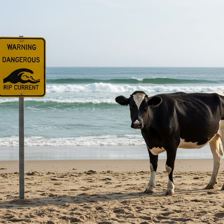

In [ ]:
# Image generated by ImageFX
image_url = "https://github.com/bebechien/gemma/blob/main/cow.jpg?raw=true"
image = read_image(image_url, target_size)
image

#### Captioning

In [ ]:
# Captioning
prompt = "cap en\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
print("-"*80)

prompt = "caption en\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
print("-"*80)

prompt = "describe en\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)

cap en
In this image we can see a cow on the sand. We can also see a pole with a board with some text on it and the water. On the backside we can see the sky.
--------------------------------------------------------------------------------
caption en
a cow standing on a beach next to a sign that says warning dangerous rip current.
--------------------------------------------------------------------------------
describe en
In this image we can see a cow on the sand. We can also see a pole with a board with some text on it and the water. On the backside we can see the sky.


#### Optical Character Recognition (OCR)

In [ ]:
# OCR
prompt = "ocr"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)


ocr
WARNING
DANGEROUS
RIP CURRENT


#### Visual Question Answering

In [ ]:
# Question Answering
prompt = "answer en where is the cow standing?\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output[len(prompt) :])

beach


#### Object Detection

detect cow
<loc0412><loc0520><loc0894><loc1022> cow


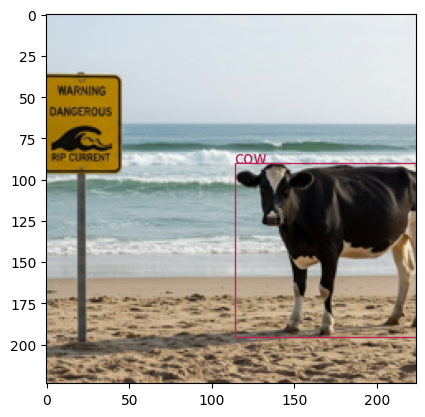

In [ ]:
prompt = 'detect cow\n'
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, target_size)

#### Prompting with natural Language

Note that the "mix" model is highly flexible, accepting natural language input for various tasks. You don't need to use precise syntax. For example, you can simply ask 'describe this image briefly' or 'what is this text' and the model will understand.

In [ ]:
prompt = "describe this image briefly.\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
print("-"*80)

prompt = "describe this image in great detail.\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
print("-"*80)

prompt = "what is the text?\n"
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)

describe this image briefly.
a cow standing on the beach next to a sign that says warning dangerous rip current.
--------------------------------------------------------------------------------
describe this image in great detail.
In this image we can see a cow on the sand. We can also see a pole with a board and some text on it. On the backside we can see the water and the sky which looks cloudy.
--------------------------------------------------------------------------------
what is the text?
warning dangerous rip current


#### Multiple Object Detection

detect chair ; table
<loc0540><loc0000><loc1022><loc0610> table ; <loc0384><loc0565><loc1022><loc0987> chair ; <loc0155><loc0861><loc0384><loc1022> chair ; <loc0355><loc0354><loc0535><loc0490> table


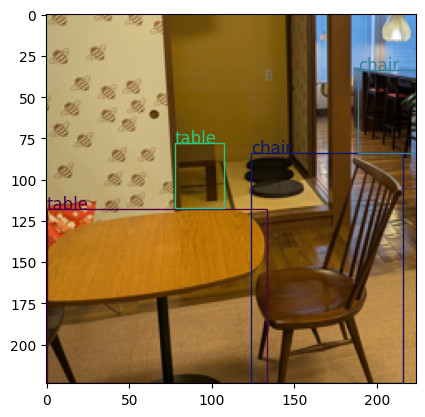

In [ ]:
image_url = "https://github.com/bebechien/gemma/blob/main/office.jpg?raw=true"
image = read_image(image_url, target_size)
prompt = 'detect chair ; table\n'
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
boxes, labels = parse_bbox_and_labels(output)
display_boxes(image, boxes, labels, target_size)

#### Segmentation

segment cat
<loc0037><loc0000><loc0910><loc0893><seg089><seg002><seg043><seg006><seg049><seg120><seg099><seg104><seg099><seg076><seg089><seg072><seg078><seg010><seg078><seg012>


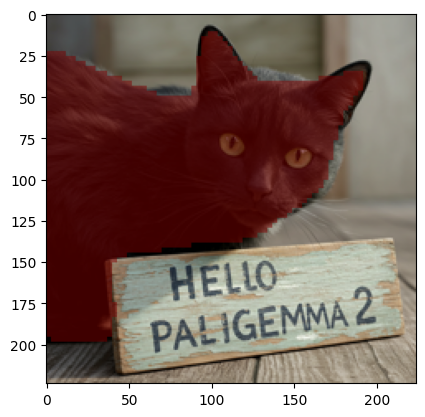

In [ ]:
image_url = "https://github.com/bebechien/gemma/blob/main/cat4.jpg?raw=true"
image = read_image(image_url, target_size)
prompt = 'segment cat\n'
output = paligemma.generate(
    inputs={
        "images": image,
        "prompts": prompt,
    }
)
print(output)
bboxes, seg_masks = parse_segments(output)
display_segment_output(image, bboxes, seg_masks, target_size)